In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import librosa
import librosa.display
import csv
from tqdm.notebook import tqdm
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import adam_v2
from keras import Input, losses

In [72]:
OUTPUT_DIR = "./"

In [73]:
IMAGE_HEIGHT = 217  
IMAGE_WIDTH =  334
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# TRAINING
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    directory=os.path.join(OUTPUT_DIR, 'Data/images_gen'),
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset="training",
    seed=0
)

# VALIDATION
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    directory=os.path.join(OUTPUT_DIR, 'Data/images_gen'),
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset="validation",
    seed=0
)

Found 1000 files belonging to 10 classes.
Using 700 files for training.
Found 1000 files belonging to 10 classes.
Using 300 files for validation.


In [74]:
#MODEL
model_cnn = keras.Sequential()
model_cnn.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', use_bias=True))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 4), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
model_cnn.add(keras.layers.Dropout(0.3))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 4), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Flatten())

# Dense Layer
model_cnn.add(keras.layers.Dense(64, activation='relu', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(N_CLASSES, activation='softmax', use_bias=True))

In [75]:
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

checkpoint_path = "Data/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=5*22 # Save checkpoint every 5 epochs (22 steps per epoch)
)

history = model_cnn.fit(
    train_dataset,
    epochs=225, 
    validation_data=valid_dataset,
    callbacks=[cp_callback]
)

Epoch 1/225
22/22 [==============================] - 2s 61ms/step - loss: 7.9576 - accuracy: 0.2386 - val_loss: 91.1019 - val_accuracy: 0.1167
Epoch 2/225
22/22 [==============================] - 1s 57ms/step - loss: 5.4514 - accuracy: 0.3800 - val_loss: 27.7108 - val_accuracy: 0.1167
Epoch 3/225
22/22 [==============================] - 1s 55ms/step - loss: 4.7038 - accuracy: 0.5171 - val_loss: 17.5430 - val_accuracy: 0.1833
Epoch 4/225
22/22 [==============================] - 1s 55ms/step - loss: 3.8565 - accuracy: 0.6186 - val_loss: 11.0939 - val_accuracy: 0.1500
Epoch 5/225
20/22 [==========================>...] - ETA: 0s - loss: 3.2339 - accuracy: 0.7031
Epoch 5: saving model to Data/training_1\cp.ckpt
22/22 [==============================] - 1s 62ms/step - loss: 3.2406 - accuracy: 0.7057 - val_loss: 4.7543 - val_accuracy: 0.3700
Epoch 6/225
22/22 [==============================] - 1s 57ms/step - loss: 2.7205 - accuracy: 0.7657 - val_loss: 4.1838 - val_accuracy: 0.3200
Epoch 7/225


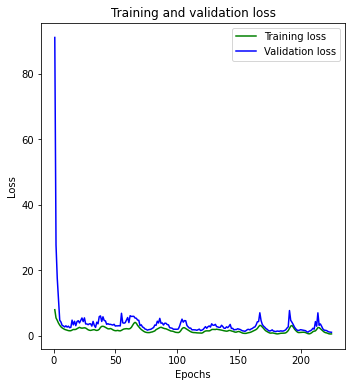

In [76]:
#LOSS
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(loss_epochs, loss_values, 'g', label='Training loss')
plt.plot(loss_epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

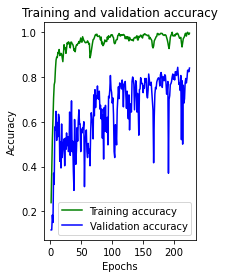

In [77]:
#ACCURACY
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
loss_epochs = range(1, len(acc_values)+1)

plt.subplot(1,2,2)
plt.plot(loss_epochs, acc_values, 'g', label='Training accuracy')
plt.plot(loss_epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [78]:
plt.show()

In [249]:
testData = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(OUTPUT_DIR, 'Data/images_gen'),
    labels='inferred',
    label_mode='categorical',
    seed=324893,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

predictions = np.array([])
labels =  np.array([])

# CREATE CSV
genres = [
    'blues',
    'classical',
    'country', 
    'disco', 
    'hiphop',
    'jazz', 
    'metal', 
    'pop',
    'reggae',
    'rock',
    'blues', # REDUNDANCY
    'blues'  # Without the extra data, rock is cut off early
]

pred = model_cnn.predict(testData)

csvdata = open("labels.csv", 'w+',newline='')
csvdata.seek(0, os.SEEK_END)
write = csv.writer(csvdata)

for i in tqdm(genres):
    for j in tqdm(sorted(os.listdir(f'./Data/genres_original/{i}'))):
        write.writerow([f'{i}/{j}'])

csvdata = open("data.csv", 'w+', newline ='')
write = csv.writer(csvdata)
for i in tqdm(genres):
    predimgs = tf.keras.preprocessing.image_dataset_from_directory(
        directory=os.path.join(OUTPUT_DIR, f'./Data/images_gen_2/{i}'),
        image_size=(IMAGE_HEIGHT,IMAGE_WIDTH)
    )
    pred = model_cnn.predict(predimgs)
    write.writerows(pred)

df1 = pd.read_csv("labels.csv")
df2 = pd.read_csv("data.csv")
df = pd.concat([df1,df2], axis=1, ignore_index=True, join='inner')
df.to_csv("csv.csv")

# Adjust for redundancy
df_firstn = pd.read_csv("csv.csv", nrows=999) # -1
df_firstn.to_csv("csv.csv",index=False)

argmax = np.argmax(pred, axis=1)

Found 1000 files belonging to 10 classes.


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


In [85]:
#UNTRAINED #MODEL
model_load = keras.Sequential()
model_load.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# 1st conv layer
model_load.add(keras.layers.Conv2D(16, (3, 3), activation='relu', use_bias=True))
model_load.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 4), padding='same'))
model_load.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_load.add(keras.layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
model_load.add(keras.layers.Dropout(0.3))
model_load.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 4), padding='same'))
model_load.add(keras.layers.BatchNormalization())
model_load.add(keras.layers.Flatten())

# Dense Layer
model_load.add(keras.layers.Dense(64, activation='relu', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
model_load.add(keras.layers.Dropout(0.3))

# output layer
model_load.add(keras.layers.Dense(N_CLASSES, activation='softmax', use_bias=True))

model_load.compile(
    loss=None,
    optimizer='adam',
    metrics=['accuracy'],
)

# Evaluate the model
loss, acc = model_load.evaluate(testData, verbose=2)
print("Untrained model accuracy: {:5.2f}%".format(100 * acc))


32/32 - 1s - loss: 2.9877 - accuracy: 0.0940 - 1s/epoch - 35ms/step
Untrained model accuracy:  9.40%


In [86]:
#LOAD WEIGHTS
model_load.load_weights(checkpoint_path)

#Evaluate the model
loss, acc = model_load.evaluate(testData, verbose=2)
print("Trained (loaded) model accuracy: {:5.2f}%".format(100 * acc))

32/32 - 1s - loss: 0.5176 - accuracy: 0.9520 - 940ms/epoch - 29ms/step
Trained (loaded) model accuracy: 95.20%


Found 1 files belonging to 1 classes.
[[1.98724074e-03 7.69896388e-01 2.05353368e-03 1.01760925e-04
  3.15894751e-04 1.91171408e-01 7.27458928e-06 7.17683928e-04
  1.56375376e-04 3.35923024e-02]]


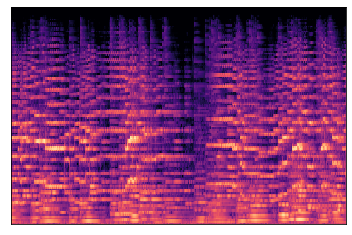

In [205]:
#Prediction
song = f'./Predict/song.wav'

#Convert to mel spectrogram image
data, sr = librosa.load(song)
mel = librosa.feature.melspectrogram(y=data, sr=sr)
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr, fmax=8000)

plt.savefig(
    f'./Predict/images_gen/song.png',
    bbox_inches='tight',
    pad_inches=0)

im = Image.open(f'./Predict/images_gen/song.png')
im = im.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
im.save('Predict/images_gen/song.png')

img = os.path.join(OUTPUT_DIR, 'Predict/images_gen/song.png')

predimg = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(OUTPUT_DIR, f'Predict'),
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH)
)

predictions_single = model_load.predict(predimg)
print(predictions_single)